## Initialize Input Files for IPMOF (initialize_IPMOF.py)

### Initialize necessary information

1. Read FF_Parameters excel file to get force field parameters for atoms
2. Initialize force field selection, cutOff radius and grid size for energy map

### Create input files for MOF files in a given directory
1. Reaf MOF files in ".mol2" format from given directory and create a list
2. Choose the first MOF1 as the stationary (map) MOF, initialize its variables, and calculate packed coordinates
3. For all the MOFs in the list:
4. Initialize MOF2 variables for the mobile MOF
5. Calculate energy map
6. Export energy map -> .json
7. Export MOF2 structure information -> .json

In [1]:
import math
import os
os.chdir('C:\\Kutay\\IPMOF')
from energyMapFunctions import *

excelFileDir = 'C:\\Users\\kutay\\iPython\\IPMOF\\FF_Parameters.xlsx'
UFF = readFFparameters(excelFileDir, 'UFF')

# Read radius list from the excel file
radiusList = readAtomRadius()

# Generate MOF list
fileDir = 'C:\\Users\kutay\\Desktop\\REFmol2'
fileFormat = ".mol2"
MOFlist = generateMOFlist(fileDir, fileFormat)
MOFnames = []

#cutOff = 13
orthoCount = 0
VFtotal = 0
MOFs = []
for MOFindex, mof in enumerate(MOFlist):
    newMOF = MOF()
    newMOF.dir = fileDir + '\\' + mof
    newMOF.file = open(newMOF.dir, 'r')
    newMOF.initialize()
    
    # Calculate void fraction
    atomVolumes = atomicVolume(newMOF, radiusList)
    UnitCellVolume = ucv(newMOF)
    newMOF.atomDensity = atomVolumes / UnitCellVolume
    newMOF.voidFraction = 1 - atomVolumes / UnitCellVolume
 
    # Calculate packing for base MOF
    newMOF.cutOff = [newMOF.UCsize[0]/2, newMOF.UCsize[1]/2, newMOF.UCsize[2]/2]
    #cutOff = [13, 13, 13]
    packingFactor = Packing.factor(newMOF.UCsize, newMOF.cutOff)
    newMOF.packingFactor = packingFactor
    translationVectors, UCvectors = Packing.vectors(packingFactor, newMOF.UCsize, newMOF.UCangle)
    newMOF.packedCoor = Packing.UC(translationVectors, packingFactor, UCvectors, newMOF.atomCoor)
    newMOF.edgePoints = Packing.edgePoints(UCvectors)
    
    if orthorhombic(newMOF):
        MOFname = MOFlist[MOFindex].split('.')[0]
        MOFname = MOFname.split('_')[0]
        newMOF.name = MOFname
        MOFs.append(newMOF)
        VFtotal += newMOF.voidFraction
        orthoCount += 1 

VFaverage = VFtotal / orthoCount

refinedMOFs = []
refinedCount = 0
table = []
for mof in MOFs:
    if mof.voidFraction > (VFaverage *1.33):
        mof.initializeFF(UFF)
        refinedMOFs.append(mof)
        table.append([])
        table[refinedCount].append(mof.name)
        table[refinedCount].append(mof.uniqueAtomNames)
        table[refinedCount].append(mof.UCsize)
        table[refinedCount].append(mof.UCangle)
        table[refinedCount].append(round(mof.voidFraction, 2))
        table[refinedCount].append(mof.packingFactor)
        refinedCount += 1
del MOFs
        
from tabulate import tabulate

headers = ["MOF Name", "Atoms", "UCsize", "UCangle", "VF", "Packing"]
print(tabulate(table, headers))

MOF Name    Atoms                       UCsize                       UCangle               VF  Packing
----------  --------------------------  ---------------------------  ------------------  ----  ---------
CUYWUP      ['H', 'O', 'C', 'Cu']       [10.6753, 17.844, 27.353]    [90.0, 90.0, 90.0]  0.95  [3, 3, 3]
DEYVUA      ['O', 'Zn', 'H', 'C', 'N']  [13.4641, 13.4641, 23.3751]  [90.0, 90.0, 90.0]  0.95  [3, 3, 3]
GUNFAW01    ['C', 'O', 'Cr', 'Mn']      [15.4901, 15.4901, 15.4901]  [90.0, 90.0, 90.0]  0.95  [3, 3, 3]
HIHNUJ      ['H', 'C', 'O', 'In']       [11.2184, 17.9218, 17.9218]  [90.0, 90.0, 90.0]  0.95  [3, 3, 3]
IRMOF-7     ['H', 'C', 'O', 'Zn']       [12.9144, 12.9144, 12.9144]  [90.0, 90.0, 90.0]  0.95  [3, 3, 3]
OFODAP      ['O', 'Cd', 'H', 'C', 'N']  [12.8597, 15.1207, 23.516]   [90.0, 90.0, 90.0]  0.95  [3, 3, 3]


In [4]:
# Creates atom list for non-repeating atoms from a list of MOF classes
atomList = getUniqueAtomList(refinedMOFs)

# Creates atom list required in the energy map of a combination of MOFs
eMapAtomList = getEnergyMapAtomList(refinedMOFs, atomList)

# Directory and format to export energy map and MOF structure files
exportFolder = "C:\\Users\\kutay\\iPython\\IPMOF\\initializeIPMOF"
exportFormat = ".js"

for MOFindex, mof in enumerate(refinedMOFs):  
           
    # Create export directory for the base MOF and create folder
    exportMOFfolder = os.path.join(exportFolder, mof.name)
    os.mkdir(exportMOFfolder)
    
    # --------------------- Calculate Energy Map -------------------
    # For each MOF energy map is calculated with an atom list that consists of all the unique atoms 
    # for a given list of MOFs
    eMap = energyMap(mof, atomList, mof.cutOff, 1)
    
    avgEnergyLimits = calculateEnergyLimits(MOFindex, refinedMOFs, MOFlist, eMapAtomList, eMap)
    
    for MOFindex2, mof2 in enumerate(refinedMOFs):
               
        # Create export directory for the mobile MOF and create folder
        exportMOFfolder2 = os.path.join(exportMOFfolder, mof2.name)
        os.mkdir(exportMOFfolder2)
        
        # Create export directory for mobile MOF
        exportDir_MOF = os.path.join(exportMOFfolder2, mof2.name + exportFormat)
        exportMOFjs(mof2, exportDir_MOF)
        print(exportDir_MOF.split("\\")[-1] + ' is exported')
             
        # Create export directory for energy map
        exportDir_eMap = os.path.join(exportMOFfolder2, mof.name + '+' + mof2.name + '_eMap' + exportFormat)
        exportUniqueEnergyMapjs(eMap, avgEnergyLimits[MOFindex2], eMapAtomList, MOFindex2, exportDir_eMap)
        print(exportDir_eMap.split("\\")[-1] + ' is exported')
        
        # Export base MOF structure
        exportDir_baseMOF = os.path.join(exportMOFfolder2, mof.name + exportFormat)
        exportBaseMOFjs(refinedMOFs[MOFindex], exportDir_baseMOF)

MOF Name      Atoms                         Average Energy Limit
------------  --------------------------  ----------------------
ABAVIJ_clean  ['H', 'Cu', 'C', 'O']                  4.95567e+11
ABAVOP_clean  ['N', 'Zn', 'H', 'C', 'O']             4.09941e+11
ABEXIQ_clean  ['Cr', 'Mn', 'C', 'O']                 4.95567e+11
ABEXOW_clean  ['In', 'H', 'C', 'O']                  4.95567e+11
ABEXUC_clean  ['Zn', 'H', 'C', 'O']                  4.95567e+11
ABEYAJ_clean  ['N', 'Cd', 'H', 'C', 'O']             4.09941e+11
CUYWUP.js is exported
CUYWUP+CUYWUP_eMap.js is exported
DEYVUA.js is exported
CUYWUP+DEYVUA_eMap.js is exported
GUNFAW01.js is exported
CUYWUP+GUNFAW01_eMap.js is exported
HIHNUJ.js is exported
CUYWUP+HIHNUJ_eMap.js is exported
IRMOF-7.js is exported
CUYWUP+IRMOF-7_eMap.js is exported
OFODAP.js is exported
CUYWUP+OFODAP_eMap.js is exported
MOF Name      Atoms                         Average Energy Limit
------------  --------------------------  ----------------------
ABAVIJ_c

In [7]:
# Calculate Energy Map
# eMap = energyMap(MOF2, atomList, cutOff, 1)

#plotEnergyMap(eMap, 90, 0)
#plotPackedCell(MOF2.packedCoor, 90, 0)

# Create export directory for the energy map
#MOFname = MOFlist[MOFselection].split('.')[0]
#MOFname = 'MOFX'
#exportFolder = "C:\\Users\\kutay\\iPython\\IPMOF\\multipleMOF"
#exportFormat = ".js"
#exportDir_eMap = os.path.join(exportFolder, MOFname + '_eMap' + exportFormat)
#exportDir_MOF = os.path.join(exportFolder, MOFname + exportFormat)
#print(exportDir_eMap)
#print(exportDir_MOF)

#eMapDir = "C:\\Users\\kutay\\iPython\\IPMOF\\eMap.js"
#exportEnergyMapjs(eMap, atomList, exportDir_eMap)

#MOFexportDir = "C:\\Users\\kutay\\iPython\\IPMOF\\MOF.js"
#exportMOFjs(MOF2, exportDir_MOF)

len(MOFs[6].atomCoor)

424

In [65]:
def findREFcodes(MOFnames):
    import os 

    cifDirectory = "C:\\Users\\kutay\\Desktop\\final_cifs"
    cifList = os.listdir(cifDirectory)
    os.chdir(cifDirectory)

    MOFformula = []
    for cifIndex, cifDir in enumerate(cifList):
        cifFile = open(cifDir, 'r')
        cifFile.readline()
        formulaLine = cifFile.readline()
        formula = formulaLine.split('_')[-1]
        formula = formula[0:len(formula)-1]
        MOFformula.append(formula)
        cifFile.close()
        cifList[cifIndex] = cifList[cifIndex].split('_')[0]

    REFcodes = [[] for i in range(len(MOFnames))]
    for cifIndex, formula in enumerate(MOFformula):
        for MOFindex, MOFname in enumerate(MOFnames):
            if formula in MOFname:
                REFcodes[MOFindex].append(cifList[cifIndex])
                
    return REFcodes

In [66]:
REFcodes = findREFcodes(MOFnames)

In [4]:
UCvectors

[[9.363, 0, 0],
 [-0.5266867638239668, 9.348174690965752, 0],
 [-0.5266867638239668, -0.5571961681359049, 9.331554130102193]]

In [15]:
MOFs[0].edgePoints

[[0, 0, 0],
 [6.5647, 0, 0],
 [-1.4670218892460913, 6.398682119504987, 0],
 [-1.9346261542700438, -2.428371802279931, 10.913965412860076],
 [5.097678110753909, 6.398682119504987, 0],
 [-3.4016480435161354, 3.970310317225056, 10.913965412860076],
 [4.630073845729957, -2.428371802279931, 8.979339258590032],
 [3.1630519564838657, 3.970310317225056, 10.913965412860076]]

In [2]:
UCedges = Packing.edgePoints(UCvectors)

In [3]:
UCedges

[[0, 0, 0],
 [9.363, 0, 0],
 [-0.5266867638239668, 9.348174690965752, 0],
 [-0.5266867638239668, -0.5571961681359049, 9.331554130102193],
 [8.836313236176032, 9.348174690965752, 0],
 [-1.0533735276479337, 8.790978522829848, 9.331554130102193],
 [8.836313236176032, -0.5571961681359049, 8.804867366278225],
 [8.309626472352065, 8.790978522829848, 9.331554130102193]]

Populating the interactive namespace from numpy and matplotlib


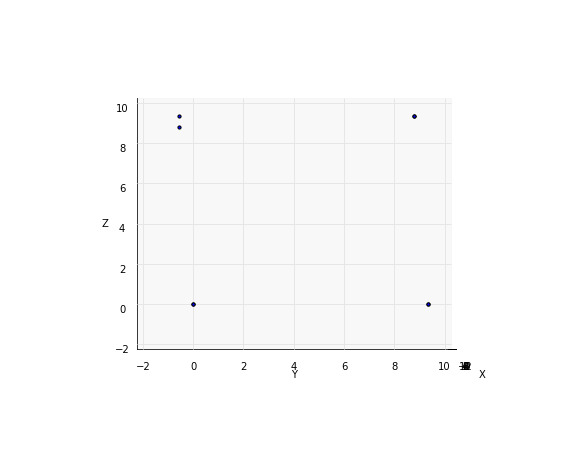

In [6]:
%pylab inline
plotXYZ(UCedges,0,0)

In [3]:
MOFs[0].atomCoor

[[0.9489, -1.7407, 9.5203],
 [2.7881, -0.7292, 5.3304],
 [0.2129, -1.9658, 9.1372],
 [2.0875, -1.04, 4.9386],
 [-0.9415, 1.7501, 4.0633],
 [-0.9964, 0.9824, 3.6802],
 [-1.4779, 4.1248, 2.6854],
 [3.3834, -1.7329, 8.1424],
 [-1.9491, 4.2543, 9.6119],
 [0.552, 5.4013, 4.0829],
 [-1.3248, 4.3508, 7.6856],
 [-0.373, 4.8038, 5.6698],
 [-2.4657, 4.0014, 7.1192],
 [-0.2169, 4.7361, 7.0122],
 [-1.4326, 4.3374, 5.0281],
 [5.5496, 0.265, 4.1549],
 [5.5041, 0.8952, 2.2286],
 [5.733, 1.9241, 0.2128],
 [5.4185, -0.295, 1.6622],
 [5.6321, 2.0611, 1.5552],
 [3.5805, -1.6412, 10.485],
 [4.174, 0.5309, 9.5399],
 [2.364, 3.0992, 5.6611],
 [3.0289, 3.2646, 4.3394],
 [4.1094, 3.8793, 5.7986],
 [3.0402, 3.3513, 5.195],
 [3.4598, 4.211, 0.2041],
 [3.8302, 6.0866, 0.3416],
 [-2.3011, 1.3405, 10.7874],
 [-2.4475, 0.5881, 10.3956],
 [1.5379, 2.4677, 9.7964],
 [1.6199, 2.498, 10.652]]

In [7]:
sortedX = sorted(MOFs[0].atomCoor, key=lambda x: x[0], reverse=True)
sortedY = sorted(MOFs[0].atomCoor, key=lambda y: y[1], reverse=True)
sortedZ = sorted(MOFs[0].atomCoor, key=lambda z: z[2], reverse=True)

In [10]:
MOFs[0].UCsize

[6.5647, 6.5647, 11.347]

In [14]:
[sortedX[0][0], sortedY[0][1], sortedZ[0][2]]

[5.733, 6.0866, 10.7874]

In [2]:
MOFs[0].edgePoints

[[0, 0, 0],
 [6.5647, 0, 0],
 [-1.4670218892460913, 6.398682119504987, 0],
 [-1.9346261542700438, -2.428371802279931, 10.913965412860076],
 [5.097678110753909, 6.398682119504987, 0],
 [-3.4016480435161354, 3.970310317225056, 10.913965412860076],
 [4.630073845729957, -2.428371802279931, 10.913965412860076],
 [3.1630519564838657, 3.970310317225056, 10.913965412860076]]

In [8]:
import math

math.ceil(-1.23)

-1

In [6]:
sortedX = sorted(MOFs[0].edgePoints, key=lambda x: x[0], reverse=True)
sortedY = sorted(MOFs[0].edgePoints, key=lambda y: y[1], reverse=True)
sortedZ = sorted(MOFs[0].edgePoints, key=lambda z: z[2], reverse=True)
eMapMax = [sortedX[0][0], sortedY[0][1], sortedZ[0][2]]
eMapMin = [sortedX[-1][0], sortedY[-1][1], sortedZ[-1][2]]
print(eMapMax)
print(eMapMin)

[6.5647, 6.398682119504987, 10.913965412860076]
[-3.4016480435161354, -2.428371802279931, 0]


In [9]:
a = [1,2,3]
min(a)

1

In [14]:
UFF

[['Ac',
  'Ag',
  'Al',
  'Am',
  'Ar',
  'As',
  'At',
  'Au',
  'B',
  'Ba',
  'Be',
  'Bi',
  'Bk',
  'Br',
  'C',
  'Ca',
  'Cd',
  'Ce',
  'Cf',
  'Cl',
  'Cm',
  'Co',
  'Cr',
  'Cs',
  'Cu',
  'Dy',
  'Er',
  'Es',
  'Eu',
  'F',
  'Fe',
  'Fm',
  'Fr',
  'Ga',
  'Gd',
  'Ge',
  'H',
  'He',
  'Hf',
  'Hg',
  'Ho',
  'I',
  'In',
  'Ir',
  'K',
  'Kr',
  'La',
  'Li',
  'Lu',
  'Lw',
  'Md',
  'Mg',
  'Mn',
  'Mo',
  'N',
  'Na',
  'Nb',
  'Nd',
  'Ne',
  'Ni',
  'No',
  'Np',
  'O',
  'Os',
  'P',
  'Pa',
  'Pb',
  'Pd',
  'Pm',
  'Po',
  'Pr',
  'Pt',
  'Pu',
  'Ra',
  'Rb',
  'Re',
  'Rh',
  'Rn',
  'Ru',
  'S',
  'Sb',
  'Sc',
  'Se',
  'Si',
  'Sm',
  'Sn',
  'Sr',
  'Ta',
  'Tb',
  'Tc',
  'Te',
  'Th',
  'Ti',
  'Tl',
  'Tm',
  'U',
  'V',
  'W',
  'Xe',
  'Y',
  'Yb',
  'Zn',
  'Zr'],
 [3.0985457416921003,
  2.8045491647057883,
  4.008153332913386,
  3.012128566032487,
  3.4459962417668324,
  3.7685015777336357,
  4.231768911166611,
  2.9337294788361374,
  3.637539466167